# Classification: Gravitational Waves

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import h5py

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

In [2]:
file = '../../sample_2e7_design_precessing_higherordermodes_3detectors.h5'
dataset = h5py.File(file)
dataset.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [3]:
#H5py read_in_files are not treated as numpy arrays!!
#Creating new ones by appending
data = []
MID_data = []

#Downsample factor for debugging
downsample = int(1e5)

#Leaving out 'det' for training!
for key in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']:
    data.append(dataset.get(key)[:downsample])
    if key == 'mtot' or key == 'q' or key == 'z':
        MID_data.append(dataset.get(key)[:downsample])

#Numpy array conversion and transposing rows and columns to match sklearn format
data = np.array(data).T
print('Whole dataset: ', data.shape)

MID_data = np.array(MID_data).T
print('Data involving mtot, q and z:', MID_data.shape)

#Gathering true labels
labels = np.array(dataset.get('det')[:downsample])

Whole dataset:  (100000, 13)
Data involving mtot, q and z: (100000, 3)


## Full set analysis

In [4]:
#Data preprocessing
size = 0.3
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size = size)

### Decision Tree Classifier

In [5]:
tree = DecisionTreeClassifier(random_state=0, max_depth=10, criterion='entropy')
tree.fit(xtrain, ytrain)
tree_ypred = tree.predict(xtest)

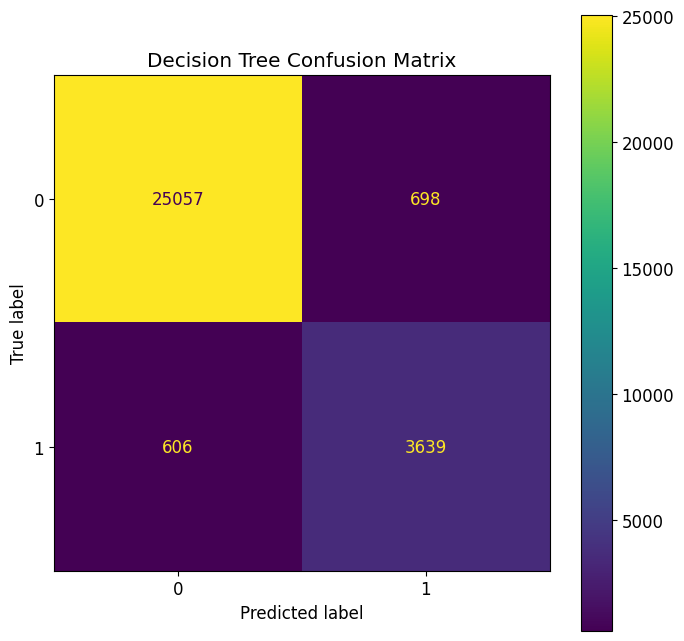

In [6]:
#Building confusion matrix
conf_matrix = confusion_matrix(ytest, tree_ypred)

#Plotting
fig, ax = plt.subplots(figsize=(8, 8))
display = ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
display.ax_.set_title('Decision Tree Confusion Matrix')
plt.show()

In [7]:
#Leaf exploration -> Find the optimal value of leaves for both completeness and contamination 
tree_completeness_test = []
tree_contamination_test = []
tree_completeness_train = []
tree_contamination_train = []

leaves = np.arange(1, 30)
for leaf in leaves:
    clf = DecisionTreeClassifier(random_state=0, max_depth=leaf,criterion='entropy')
    clf.fit(xtrain, ytrain)

    #Gathering true positive, true negative, false positive and false negative for test subset from confusion matrix
    tree_ytest_pred = clf.predict(xtest)
    tree_test_confusion = confusion_matrix(ytest, tree_ytest_pred)
    trueneg, falsepos, falseneg, truepos = tree_test_confusion.ravel()
    tree_completeness_test.append(truepos / (truepos + falseneg))
    tree_contamination_test.append(falsepos / (truepos + falsepos))

    #Gathering true positive, true negative, false positive and false negative for train subset from confusion matrix
    tree_ytrain_pred = clf.predict(xtrain)
    tree_train_confusion = confusion_matrix(ytrain, tree_ytrain_pred)
    trueneg, falsepos, falseneg, truepos = tree_train_confusion.ravel()
    tree_completeness_train.append(truepos / (truepos + falseneg))
    tree_contamination_train.append(falsepos / (truepos + falsepos))

In [8]:
#Cross-Validation on optimal leaf number!
tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
gscv = GridSearchCV(tree, param_grid={'max_depth': leaves}, cv=5, n_jobs=-1)
gscv.fit(xtrain, ytrain)

best = gscv.best_params_['max_depth']
print("Best leaf number:", best)

Best leaf number: 8


In [9]:
#Completeness and contamination at the optimal leaf
print(f'Test Completeness for decision tree with depth {best}: {tree_completeness_test[best - 1]}')
print(f'Train Completeness for decision tree with depth {best}: {tree_completeness_train[best - 1]}')
print(f'Test Contamination for decision tree with depth {best}: {tree_contamination_test[best - 1]}')
print(f'Train Contamination for decision tree with depth {best}: {tree_contamination_train[best - 1]}')

Test Completeness for decision tree with depth 8: 0.8327444051825678
Train Completeness for decision tree with depth 8: 0.8559731676038276
Test Contamination for decision tree with depth 8: 0.1356968215158924
Train Contamination for decision tree with depth 8: 0.11513359167856414


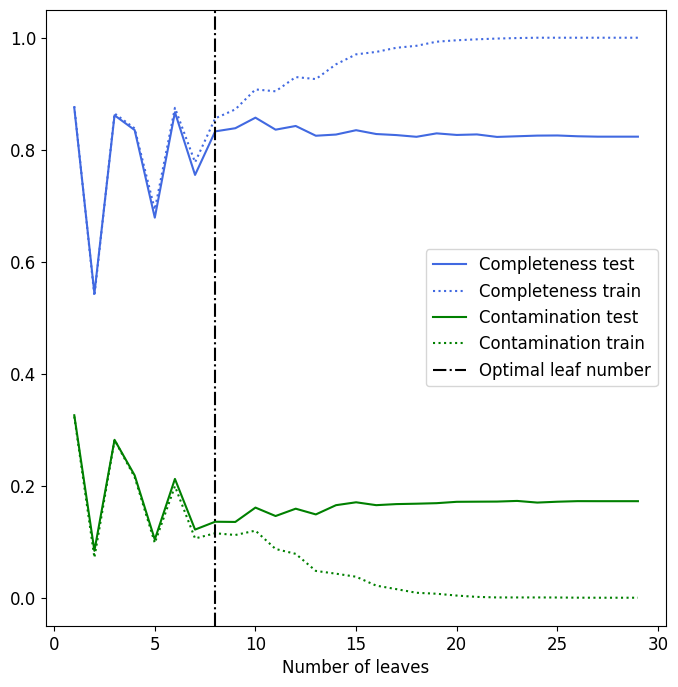

In [10]:
#Plotting

#Completeness
plt.plot(leaves, tree_completeness_test, label='Completeness test', c='royalblue')
plt.plot(leaves, tree_completeness_train, label='Completeness train', c='royalblue', ls='dotted')

#Contamination
plt.plot(leaves, tree_contamination_test, label='Contamination test', c='green')
plt.plot(leaves, tree_contamination_train, label='Contamination train', c='green', ls='dotted')

#Cross-Validated optimal leaf number
plt.axvline(x=best, c='k', ls='-.', label='Optimal leaf number')

plt.xlabel('Number of leaves')
plt.legend()
plt.show()

### Random Forest

In [11]:
#Random Forest
forest = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=best, criterion='entropy', n_jobs=-1)
clf.fit(xtrain, ytrain)

#Test subset
forest_test_ypred = clf.predict(xtest)
forest_test_confusion = confusion_matrix(ytest, forest_test_ypred)
trueneg, falsepos, falseneg, truepos = forest_test_confusion.ravel()
forest_test_completeness = truepos / (truepos + falseneg)
forest_test_contamination = falsepos / (truepos + falsepos)

print(f'Test Completeness for random forest with depth {best}: {forest_test_completeness}')
print(f'Test Contamination for random forest with depth {best}: {forest_test_contamination}')

#Train subset
forest_train_ypred = clf.predict(xtrain)
forest_train_confusion = confusion_matrix(ytrain, forest_train_ypred)
trueneg, falsepos, falseneg, truepos = forest_train_confusion.ravel()
forest_train_completeness = truepos / (truepos + falseneg)
forest_train_contamination = falsepos / (truepos + falsepos)

print(f'Train Completeness for random forest with depth {best}: {forest_train_completeness}')
print(f'Train Contamination for random forest with depth {best}: {forest_train_contamination}')

Test Completeness for random forest with depth 8: 0.823321554770318
Test Contamination for random forest with depth 8: 0.17238929670850106
Train Completeness for random forest with depth 8: 1.0
Train Contamination for random forest with depth 8: 0.0


### Comparing to single decision tree

In [12]:
print(f'Test Completeness for random forest with depth {best}: {forest_test_completeness}')
print(f'Test Completeness for decision tree with depth {best}: {tree_completeness_test[best - 1]}\n')

print(f'Test Contamination for random forest with depth {best}: {forest_test_contamination}')
print(f'Test Contamination for decision tree with depth {best}: {tree_contamination_test[best - 1]}\n')

print(f'Train Completeness for random forest with depth {best}: {forest_train_completeness}')
print(f'Train Completeness for decision tree with depth {best}: {tree_completeness_train[best - 1]}\n')

print(f'Train Contamination for random forest with depth {best}: {forest_train_contamination}')
print(f'Train Contamination for decision tree with depth {best}: {tree_contamination_train[best - 1]}\n')


Test Completeness for random forest with depth 8: 0.823321554770318
Test Completeness for decision tree with depth 8: 0.8327444051825678

Test Contamination for random forest with depth 8: 0.17238929670850106
Test Contamination for decision tree with depth 8: 0.1356968215158924

Train Completeness for random forest with depth 8: 1.0
Train Completeness for decision tree with depth 8: 0.8559731676038276

Train Contamination for random forest with depth 8: 0.0
Train Contamination for decision tree with depth 8: 0.11513359167856414



## More Interesting Data (mtot, q, z)

In [14]:
#Data preprocessing
size = 0.3
xtrain, xtest, ytrain, ytest = train_test_split(MID_data, labels, test_size = size)

### Decision Tree Classifier

In [15]:
tree = DecisionTreeClassifier(random_state=0, max_depth=10, criterion='entropy')
tree.fit(xtrain, ytrain)
tree_ypred = tree.predict(xtest)

In [16]:
#Building confusion matrix
conf_matrix = confusion_matrix(ytest, tree_ypred)

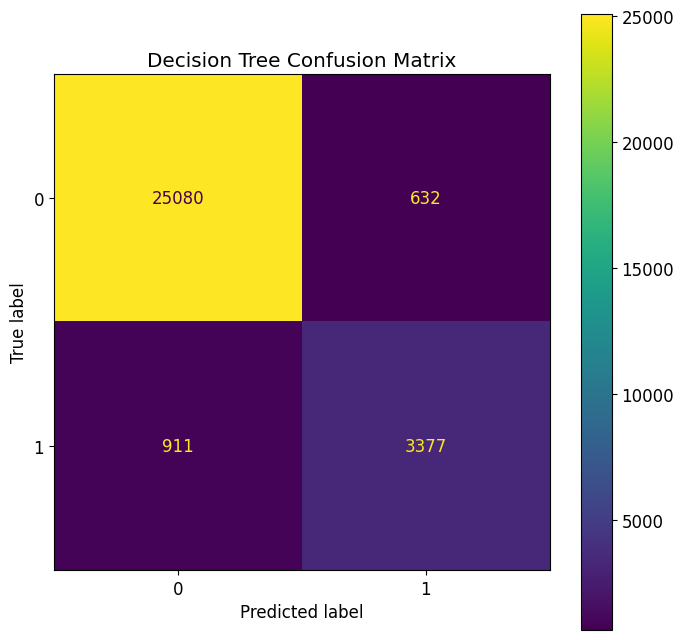

In [17]:
#Plotting
fig, ax = plt.subplots(figsize=(8, 8))
display = ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
display.ax_.set_title('Decision Tree Confusion Matrix')
plt.show()

In [18]:
#Leaf exploration -> Find the optimal value of leaves for both completeness and contamination 
tree_completeness_test = []
tree_contamination_test = []
tree_completeness_train = []
tree_contamination_train = []

leaves = np.arange(1, 30)
for leaf in leaves:
    clf = DecisionTreeClassifier(random_state=0, max_depth=leaf,criterion='entropy')
    clf.fit(xtrain, ytrain)

    #Gathering true positive, true negative, false positive and false negative for test subset from confusion matrix
    tree_ytest_pred = clf.predict(xtest)
    tree_test_confusion = confusion_matrix(ytest, tree_ytest_pred)
    trueneg, falsepos, falseneg, truepos = tree_test_confusion.ravel()
    tree_completeness_test.append(truepos / (truepos + falseneg))
    tree_contamination_test.append(falsepos / (truepos + falsepos))

    #Gathering true positive, true negative, false positive and false negative for train subset from confusion matrix
    tree_ytrain_pred = clf.predict(xtrain)
    tree_train_confusion = confusion_matrix(ytrain, tree_ytrain_pred)
    trueneg, falsepos, falseneg, truepos = tree_train_confusion.ravel()
    tree_completeness_train.append(truepos / (truepos + falseneg))
    tree_contamination_train.append(falsepos / (truepos + falsepos))

In [19]:
#Cross-Validation on optimal leaf number!
tree = DecisionTreeClassifier(random_state=0, criterion='entropy')
gscv = GridSearchCV(tree, param_grid={'max_depth': leaves}, cv=5, n_jobs=-1)
gscv.fit(xtrain, ytrain)

best = gscv.best_params_['max_depth']
print("Best leaf number:", best)

Best leaf number: 8


In [20]:
#Completeness and contamination at the optimal leaf
print(f'Test Completeness for decision tree with depth {best}: {tree_completeness_test[best - 1]}')
print(f'Train Completeness for decision tree with depth {best}: {tree_completeness_train[best - 1]}')
print(f'Test Contamination for decision tree with depth {best}: {tree_contamination_test[best - 1]}')
print(f'Train Contamination for decision tree with depth {best}: {tree_contamination_train[best - 1]}')

Test Completeness for decision tree with depth 8: 0.7740205223880597
Train Completeness for decision tree with depth 8: 0.7837329106399842
Test Contamination for decision tree with depth 8: 0.14037814037814036
Train Contamination for decision tree with depth 8: 0.1293198327096632


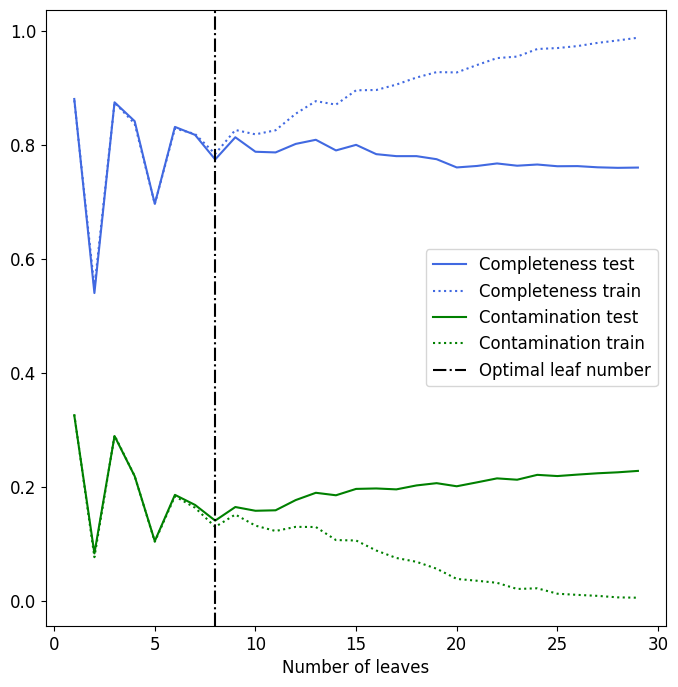

In [21]:
#Plotting

#Completeness
plt.plot(leaves, tree_completeness_test, label='Completeness test', c='royalblue')
plt.plot(leaves, tree_completeness_train, label='Completeness train', c='royalblue', ls='dotted')

#Contamination
plt.plot(leaves, tree_contamination_test, label='Contamination test', c='green')
plt.plot(leaves, tree_contamination_train, label='Contamination train', c='green', ls='dotted')

#Cross-Validated optimal leaf number
plt.axvline(x=best, c='k', ls='-.', label='Optimal leaf number')

plt.xlabel('Number of leaves')
plt.legend()
plt.show()

### Random Forest

In [22]:
#Random Forest
forest = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=best, criterion='entropy', n_jobs=-1)
clf.fit(xtrain, ytrain)

#Test subset
forest_test_ypred = clf.predict(xtest)
forest_test_confusion = confusion_matrix(ytest, forest_test_ypred)
trueneg, falsepos, falseneg, truepos = forest_test_confusion.ravel()
forest_test_completeness = truepos / (truepos + falseneg)
forest_test_contamination = falsepos / (truepos + falsepos)

print(f'Test Completeness for random forest with depth {best}: {forest_test_completeness}')
print(f'Test Contamination for random forest with depth {best}: {forest_test_contamination}')

#Train subset
forest_train_ypred = clf.predict(xtrain)
forest_train_confusion = confusion_matrix(ytrain, forest_train_ypred)
trueneg, falsepos, falseneg, truepos = forest_train_confusion.ravel()
forest_train_completeness = truepos / (truepos + falseneg)
forest_train_contamination = falsepos / (truepos + falsepos)

print(f'Train Completeness for random forest with depth {best}: {forest_train_completeness}')
print(f'Train Contamination for random forest with depth {best}: {forest_train_contamination}')

Test Completeness for random forest with depth 8: 0.7597947761194029
Test Contamination for random forest with depth 8: 0.22759601706970128
Train Completeness for random forest with depth 8: 0.9876164057856153
Train Contamination for random forest with depth 8: 0.005089820359281437


In [23]:
print(f'Test Completeness for random forest with depth {best}: {forest_test_completeness}')
print(f'Test Completeness for decision tree with depth {best}: {tree_completeness_test[best - 1]}\n')

print(f'Test Contamination for random forest with depth {best}: {forest_test_contamination}')
print(f'Test Contamination for decision tree with depth {best}: {tree_contamination_test[best - 1]}\n')

print(f'Train Completeness for random forest with depth {best}: {forest_train_completeness}')
print(f'Train Completeness for decision tree with depth {best}: {tree_completeness_train[best - 1]}\n')

print(f'Train Contamination for random forest with depth {best}: {forest_train_contamination}')
print(f'Train Contamination for decision tree with depth {best}: {tree_contamination_train[best - 1]}\n')

Test Completeness for random forest with depth 8: 0.7597947761194029
Test Completeness for decision tree with depth 8: 0.7740205223880597

Test Contamination for random forest with depth 8: 0.22759601706970128
Test Contamination for decision tree with depth 8: 0.14037814037814036

Train Completeness for random forest with depth 8: 0.9876164057856153
Train Completeness for decision tree with depth 8: 0.7837329106399842

Train Contamination for random forest with depth 8: 0.005089820359281437
Train Contamination for decision tree with depth 8: 0.1293198327096632

